In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sb
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import sklearn.linear_model as lm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
import sklearn.impute as im

from datetime import timedelta
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


/Users/thee/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/thee/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!ls gdrive/MyDrive/'AC297r Capstone QB Group'/Data

In [ ]:
# df_full = pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/USDM_SMAP_SET_NOAA_full.csv')
# df_stl_region = pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/USDM_SMAP_SET_NOAA_STL_full.csv')

df_full = pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/USDM_SMAP_SET_NOAA_STL_full.csv')

train_counties, test_counties = pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/train_counties.csv'),pd.read_csv('gdrive/MyDrive/AC297r Capstone QB Group/Data/test_counties.csv')

df_full[df_full == -9999] = np.nan

train_counties.reset_index(inplace = True)
test_counties.reset_index(inplace = True)

df_full['test'] = [1 if fip in test_counties['FIPS'].unique() else 0 for fip in df_full['FIPS']]


df_full['MapDate'] = pd.to_datetime(df_full['MapDate'])

df_full.columns

In [ ]:
df_full

In [ ]:
train_test_split_date = '2019-06-01'
train_df = df_full[df_full['MapDate'] < datetime.strptime(train_test_split_date, '%Y-%M-%d')].dropna()
test_df = df_full[df_full['MapDate'] >= datetime.strptime(train_test_split_date, '%Y-%M-%d')].dropna()

In [ ]:
X_list = ['roff', 'evap', 'smap', 'PRCP', 'SNWD', 'TMAX', 'TMIN', 'NDVI_1', 'NDVI_2', 'NDVI_diff', 'NDRE_1', 'NDRE_2', 'NDRE_diff']
# auto regression y to x
y_list = ['None', 'D0', 'D1', 'D2', 'D3', 'D4', 'wsum']

In [ ]:
scaler = Normalizer()    ### Normalize to 0 to 1
scaler.fit(train_df[X_list])
train_df[X_list] = scaler.transform(train_df[X_list])
test_df[X_list] = scaler.transform(test_df[X_list])

In [ ]:
X_list = X_list + y_list

In [ ]:
FIPS_list = list(df_full['FIPS'].unique())
lookback = 26
lag = 8
threshold = 50

In [ ]:
# create training sequnetial data
X_train, y_train = [], []
for FIPS in tqdm(FIPS_list):
  temp = train_df[train_df['FIPS'] == FIPS].sort_values('MapDate')
  for i in range(temp.shape[0]-lookback-lag):
    X_train.append(temp[X_list].iloc[i:i+lookback, :].values)
    y_train.append(temp['None'].iloc[i+lookback+lag] > threshold)
X_train, y_train = np.swapaxes(np.array(X_train), 1, 2), np.array(y_train)
print(X_train.shape, y_train.shape)

In [ ]:
# create testing sequnetial data
X_test, y_test = [], []
for FIPS in tqdm(FIPS_list):
  temp = test_df[test_df['FIPS'] == FIPS].sort_values('MapDate')
  for i in range(temp.shape[0]-lookback-lag):
    X_test.append(temp[X_list].iloc[i:i+lookback, :].values)
    y_test.append(temp['None'].iloc[i+lookback+lag] > threshold)
X_test, y_test = np.swapaxes(np.array(X_test), 1, 2), np.array(y_test)
print(X_test.shape, y_test.shape)

In [ ]:
# create LSTM model
model = Sequential()
model.add(LSTM(5, input_shape=(X_train.shape[1], lookback)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

In [ ]:
score = model.evaluate(X_test, y_test)

In [ ]:
y_pred_test = model.predict(X_test)

In [ ]:
lr_fpr, lr_tpr, _ = roc_curve(1*y_test, y_pred_test.flatten())
ns_fpr, ns_tpr, _ = roc_curve(1*y_test, np.ones(y_test.shape[0]))

# calculate scores
ns_auc = roc_auc_score(1*y_test, np.ones(y_test.shape[0]))
lr_auc = roc_auc_score(1*y_test, y_pred_test.flatten())

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.809


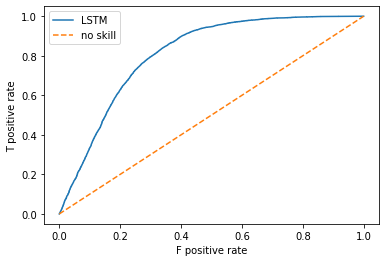

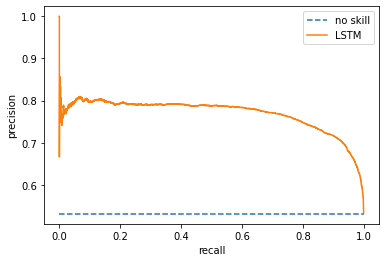

In [63]:
# lr_fpr, lr_tpr, _ = roc_curve(res[5], res[0].predict_proba(res[4])[:,1])
# ns_fpr, ns_tpr, _ = roc_curve(res[5], np.ones(len(res[5])))

# # calculate scores
# ns_auc = roc_auc_score(res[5], np.ones(len(res[5])))
# lr_auc = roc_auc_score(res[5], res[0].predict_proba(res[4])[:,1])
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
plt.plot(lr_fpr, lr_tpr, label = 'LSTM')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label = 'no skill')
plt.legend()
plt.xlabel('F positive rate')
plt.ylabel('T positive rate')
plt.show()

# Precision-Recall curve
lr_precision, lr_recall, _ = precision_recall_curve(1*y_test, y_pred_test.flatten())
ns = y_test[y_test].sum() / len(y_test)
plt.plot([0, 1], [ns, ns], linestyle='--', label='no skill')
plt.plot(lr_recall, lr_precision, label='LSTM')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.show()

Run for different numbers of lags and prediction weeks

In [64]:
d_score = {}
for lookback in [4, 8, 12, 26, 52]:
  for week in [4, 8, 12, 26, 52]:
    print(lookback, week)
    X_train, y_train = [], []
    for FIPS in tqdm(FIPS_list):
      temp = train_df[train_df['FIPS'] == FIPS].sort_values('MapDate')
      for i in range(temp.shape[0]-lookback-week):
        X_train.append(temp[X_list].iloc[i:i+lookback, :].values)
        y_train.append(temp['None'].iloc[i+lookback+week] > threshold)
    X_train, y_train = np.swapaxes(np.array(X_train), 1, 2), np.array(y_train)

    X_test, y_test = [], []
    for FIPS in tqdm(FIPS_list):
      temp = test_df[test_df['FIPS'] == FIPS].sort_values('MapDate')
      for i in range(temp.shape[0]-lookback-week):
        X_test.append(temp[X_list].iloc[i:i+lookback, :].values)
        y_test.append(temp['None'].iloc[i+lookback+week] > threshold)
    X_test, y_test = np.swapaxes(np.array(X_test), 1, 2), np.array(y_test)

    # create LSTM model
    model = Sequential()
    model.add(LSTM(5, input_shape=(X_train.shape[1], lookback)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=64)
    score = model.evaluate(X_test, y_test)
    d_score[(lookback, week)] = score[1]

4 4


100%|██████████| 450/450 [00:18<00:00, 24.03it/s]


Epoch 1/10
314/314 [==============================] - 23s 7ms/step - loss: 0.5449 - accuracy: 0.7593
Epoch 2/10
314/314 [==============================] - 2s 7ms/step - loss: 0.4640 - accuracy: 0.8072
Epoch 3/10
314/314 [==============================] - 2s 7ms/step - loss: 0.4530 - accuracy: 0.8108
Epoch 4/10
314/314 [==============================] - 2s 7ms/step - loss: 0.4484 - accuracy: 0.8139
Epoch 5/10
314/314 [==============================] - 2s 8ms/step - loss: 0.4454 - accuracy: 0.8143
Epoch 6/10
314/314 [==============================] - 2s 7ms/step - loss: 0.4436 - accuracy: 0.8144
Epoch 7/10
314/314 [==============================] - 2s 8ms/step - loss: 0.4416 - accuracy: 0.8166
Epoch 8/10
314/314 [==============================] - 2s 8ms/step - loss: 0.4403 - accuracy: 0.8166
Epoch 9/10
314/314 [==============================] - 3s 8ms/step - loss: 0.4393 - accuracy: 0.8166
Epoch 10/10
927/927 [==============================] - 3s 2ms/step - loss: 0.3804 - accuracy: 0.848

100%|██████████| 450/450 [00:17<00:00, 25.17it/s]


Epoch 1/10
299/299 [==============================] - 5s 9ms/step - loss: 0.6163 - accuracy: 0.6840
Epoch 2/10
299/299 [==============================] - 2s 7ms/step - loss: 0.5567 - accuracy: 0.7333
Epoch 3/10
299/299 [==============================] - 2s 8ms/step - loss: 0.5520 - accuracy: 0.7360
Epoch 4/10
299/299 [==============================] - 2s 7ms/step - loss: 0.5491 - accuracy: 0.7387
Epoch 5/10
299/299 [==============================] - 2s 8ms/step - loss: 0.5490 - accuracy: 0.7374
Epoch 6/10
299/299 [==============================] - 2s 7ms/step - loss: 0.5471 - accuracy: 0.7400
Epoch 7/10
299/299 [==============================] - 2s 7ms/step - loss: 0.5477 - accuracy: 0.7401
Epoch 8/10
299/299 [==============================] - 2s 7ms/step - loss: 0.5471 - accuracy: 0.7394
Epoch 9/10
299/299 [==============================] - 2s 7ms/step - loss: 0.5463 - accuracy: 0.7406
Epoch 10/10
897/897 [==============================] - 3s 2ms/step - loss: 0.4941 - accuracy: 0.7910

100%|██████████| 450/450 [00:17<00:00, 25.84it/s]


Epoch 1/10
284/284 [==============================] - 4s 7ms/step - loss: 0.6307 - accuracy: 0.6534
Epoch 2/10
284/284 [==============================] - 2s 7ms/step - loss: 0.6088 - accuracy: 0.6549
Epoch 3/10
284/284 [==============================] - 2s 7ms/step - loss: 0.6044 - accuracy: 0.6705
Epoch 4/10
284/284 [==============================] - 2s 7ms/step - loss: 0.6035 - accuracy: 0.6805
Epoch 5/10
284/284 [==============================] - 2s 7ms/step - loss: 0.6027 - accuracy: 0.6795
Epoch 6/10
284/284 [==============================] - 2s 7ms/step - loss: 0.6016 - accuracy: 0.6855
Epoch 7/10
284/284 [==============================] - 2s 8ms/step - loss: 0.6011 - accuracy: 0.6865
Epoch 8/10
284/284 [==============================] - 2s 7ms/step - loss: 0.5999 - accuracy: 0.6882
Epoch 9/10
284/284 [==============================] - 2s 7ms/step - loss: 0.6009 - accuracy: 0.6874
Epoch 10/10
868/868 [==============================] - 3s 3ms/step - loss: 0.5768 - accuracy: 0.7508

100%|██████████| 450/450 [00:15<00:00, 29.39it/s]


Epoch 1/10
233/233 [==============================] - 4s 7ms/step - loss: 0.6841 - accuracy: 0.5851
Epoch 2/10
233/233 [==============================] - 2s 8ms/step - loss: 0.6629 - accuracy: 0.5948
Epoch 3/10
233/233 [==============================] - 2s 7ms/step - loss: 0.6575 - accuracy: 0.6239
Epoch 4/10
233/233 [==============================] - 2s 7ms/step - loss: 0.6547 - accuracy: 0.6256
Epoch 5/10
233/233 [==============================] - 2s 7ms/step - loss: 0.6529 - accuracy: 0.6290
Epoch 6/10
233/233 [==============================] - 2s 7ms/step - loss: 0.6516 - accuracy: 0.6285
Epoch 7/10
233/233 [==============================] - 2s 7ms/step - loss: 0.6511 - accuracy: 0.6291
Epoch 8/10
233/233 [==============================] - 2s 8ms/step - loss: 0.6502 - accuracy: 0.6291
Epoch 9/10
233/233 [==============================] - 2s 7ms/step - loss: 0.6497 - accuracy: 0.6281
Epoch 10/10
766/766 [==============================] - 2s 2ms/step - loss: 0.6440 - accuracy: 0.6274

100%|██████████| 450/450 [00:11<00:00, 37.91it/s]


Epoch 1/10
143/143 [==============================] - 3s 9ms/step - loss: 0.6806 - accuracy: 0.6221
Epoch 2/10
143/143 [==============================] - 1s 8ms/step - loss: 0.6704 - accuracy: 0.6231
Epoch 3/10
143/143 [==============================] - 1s 8ms/step - loss: 0.6635 - accuracy: 0.6233
Epoch 4/10
143/143 [==============================] - 1s 7ms/step - loss: 0.6619 - accuracy: 0.6235
Epoch 5/10
143/143 [==============================] - 1s 7ms/step - loss: 0.6610 - accuracy: 0.6236
Epoch 6/10
143/143 [==============================] - 1s 7ms/step - loss: 0.6607 - accuracy: 0.6242
Epoch 7/10
143/143 [==============================] - 1s 7ms/step - loss: 0.6603 - accuracy: 0.6244
Epoch 8/10
143/143 [==============================] - 1s 8ms/step - loss: 0.6603 - accuracy: 0.6247
Epoch 9/10
143/143 [==============================] - 1s 7ms/step - loss: 0.6600 - accuracy: 0.6251
Epoch 10/10
583/583 [==============================] - 2s 3ms/step - loss: 0.7310 - accuracy: 0.4815

100%|██████████| 450/450 [00:18<00:00, 24.55it/s]


Epoch 1/10
299/299 [==============================] - 4s 8ms/step - loss: 0.5822 - accuracy: 0.7370
Epoch 2/10
299/299 [==============================] - 2s 8ms/step - loss: 0.4933 - accuracy: 0.7694
Epoch 3/10
299/299 [==============================] - 2s 8ms/step - loss: 0.4733 - accuracy: 0.8017
Epoch 4/10
299/299 [==============================] - 2s 7ms/step - loss: 0.4667 - accuracy: 0.8061
Epoch 5/10
299/299 [==============================] - 2s 7ms/step - loss: 0.4624 - accuracy: 0.8078
Epoch 6/10
299/299 [==============================] - 2s 7ms/step - loss: 0.4587 - accuracy: 0.8095
Epoch 7/10
299/299 [==============================] - 2s 7ms/step - loss: 0.4568 - accuracy: 0.8102
Epoch 8/10
299/299 [==============================] - 2s 7ms/step - loss: 0.4556 - accuracy: 0.8105
Epoch 9/10
299/299 [==============================] - 2s 7ms/step - loss: 0.4539 - accuracy: 0.8105
Epoch 10/10
897/897 [==============================] - 3s 2ms/step - loss: 0.4245 - accuracy: 0.8422

100%|██████████| 450/450 [00:17<00:00, 26.09it/s]


Epoch 1/10
284/284 [==============================] - 4s 8ms/step - loss: 0.6488 - accuracy: 0.6368
Epoch 2/10
284/284 [==============================] - 2s 7ms/step - loss: 0.5787 - accuracy: 0.7276
Epoch 3/10
284/284 [==============================] - 2s 7ms/step - loss: 0.5733 - accuracy: 0.7286
Epoch 4/10
284/284 [==============================] - 2s 7ms/step - loss: 0.5709 - accuracy: 0.7295
Epoch 5/10
284/284 [==============================] - 2s 8ms/step - loss: 0.5688 - accuracy: 0.7320
Epoch 6/10
284/284 [==============================] - 2s 7ms/step - loss: 0.5660 - accuracy: 0.7315
Epoch 7/10
284/284 [==============================] - 2s 7ms/step - loss: 0.5640 - accuracy: 0.7309
Epoch 8/10
284/284 [==============================] - 2s 8ms/step - loss: 0.5624 - accuracy: 0.7341
Epoch 9/10
284/284 [==============================] - 2s 7ms/step - loss: 0.5610 - accuracy: 0.7338
Epoch 10/10
868/868 [==============================] - 3s 2ms/step - loss: 0.5362 - accuracy: 0.7840

100%|██████████| 450/450 [00:17<00:00, 26.47it/s]


Epoch 1/10
269/269 [==============================] - 4s 7ms/step - loss: 0.6524 - accuracy: 0.6487
Epoch 2/10
269/269 [==============================] - 2s 7ms/step - loss: 0.6179 - accuracy: 0.6811
Epoch 3/10
269/269 [==============================] - 2s 7ms/step - loss: 0.6125 - accuracy: 0.6910
Epoch 4/10
269/269 [==============================] - 2s 7ms/step - loss: 0.6093 - accuracy: 0.6932
Epoch 5/10
269/269 [==============================] - 2s 7ms/step - loss: 0.6077 - accuracy: 0.6930
Epoch 6/10
269/269 [==============================] - 2s 7ms/step - loss: 0.6060 - accuracy: 0.6970
Epoch 7/10
269/269 [==============================] - 2s 7ms/step - loss: 0.6054 - accuracy: 0.6965
Epoch 8/10
269/269 [==============================] - 2s 8ms/step - loss: 0.6044 - accuracy: 0.6963
Epoch 9/10
269/269 [==============================] - 2s 7ms/step - loss: 0.6035 - accuracy: 0.6955
Epoch 10/10
839/839 [==============================] - 3s 2ms/step - loss: 0.5793 - accuracy: 0.7357

100%|██████████| 450/450 [00:15<00:00, 29.76it/s]


Epoch 1/10
219/219 [==============================] - 4s 7ms/step - loss: 0.6740 - accuracy: 0.6012
Epoch 2/10
219/219 [==============================] - 2s 7ms/step - loss: 0.6542 - accuracy: 0.6218
Epoch 3/10
219/219 [==============================] - 2s 7ms/step - loss: 0.6516 - accuracy: 0.6249
Epoch 4/10
219/219 [==============================] - 2s 7ms/step - loss: 0.6542 - accuracy: 0.6204
Epoch 5/10
219/219 [==============================] - 2s 7ms/step - loss: 0.6521 - accuracy: 0.6242
Epoch 6/10
219/219 [==============================] - 2s 7ms/step - loss: 0.6497 - accuracy: 0.6265
Epoch 7/10
219/219 [==============================] - 2s 7ms/step - loss: 0.6495 - accuracy: 0.6278
Epoch 8/10
219/219 [==============================] - 2s 8ms/step - loss: 0.6474 - accuracy: 0.6275
Epoch 9/10
219/219 [==============================] - 2s 8ms/step - loss: 0.6456 - accuracy: 0.6275
Epoch 10/10
737/737 [==============================] - 2s 3ms/step - loss: 0.6460 - accuracy: 0.6581

100%|██████████| 450/450 [00:11<00:00, 39.28it/s]


Epoch 1/10
130/130 [==============================] - 3s 8ms/step - loss: 0.6646 - accuracy: 0.6332
Epoch 2/10
130/130 [==============================] - 1s 7ms/step - loss: 0.6545 - accuracy: 0.6397
Epoch 3/10
130/130 [==============================] - 1s 7ms/step - loss: 0.6525 - accuracy: 0.6400
Epoch 4/10
130/130 [==============================] - 1s 7ms/step - loss: 0.6520 - accuracy: 0.6400
Epoch 5/10
130/130 [==============================] - 1s 7ms/step - loss: 0.6511 - accuracy: 0.6412
Epoch 6/10
130/130 [==============================] - 1s 7ms/step - loss: 0.6506 - accuracy: 0.6419
Epoch 7/10
130/130 [==============================] - 1s 7ms/step - loss: 0.6502 - accuracy: 0.6418
Epoch 8/10
130/130 [==============================] - 1s 7ms/step - loss: 0.6495 - accuracy: 0.6416
Epoch 9/10
130/130 [==============================] - 1s 7ms/step - loss: 0.6487 - accuracy: 0.6400
Epoch 10/10
556/556 [==============================] - 2s 2ms/step - loss: 0.7568 - accuracy: 0.4666

100%|██████████| 450/450 [00:17<00:00, 25.88it/s]


Epoch 1/10
284/284 [==============================] - 4s 8ms/step - loss: 0.6156 - accuracy: 0.6920
Epoch 2/10
284/284 [==============================] - 2s 8ms/step - loss: 0.5120 - accuracy: 0.7875
Epoch 3/10
284/284 [==============================] - 2s 8ms/step - loss: 0.4939 - accuracy: 0.7937
Epoch 4/10
284/284 [==============================] - 2s 8ms/step - loss: 0.4868 - accuracy: 0.7951
Epoch 5/10
284/284 [==============================] - 2s 7ms/step - loss: 0.4823 - accuracy: 0.7964
Epoch 6/10
284/284 [==============================] - 2s 7ms/step - loss: 0.4797 - accuracy: 0.7978
Epoch 7/10
284/284 [==============================] - 2s 8ms/step - loss: 0.4781 - accuracy: 0.7984
Epoch 8/10
284/284 [==============================] - 2s 7ms/step - loss: 0.4745 - accuracy: 0.8003
Epoch 9/10
284/284 [==============================] - 2s 7ms/step - loss: 0.4740 - accuracy: 0.7993
Epoch 10/10
868/868 [==============================] - 3s 3ms/step - loss: 0.4398 - accuracy: 0.8241

100%|██████████| 450/450 [00:17<00:00, 26.06it/s]


Epoch 1/10
269/269 [==============================] - 4s 7ms/step - loss: 0.6346 - accuracy: 0.6173
Epoch 2/10
269/269 [==============================] - 2s 7ms/step - loss: 0.5968 - accuracy: 0.6825
Epoch 3/10
269/269 [==============================] - 2s 8ms/step - loss: 0.5831 - accuracy: 0.7189
Epoch 4/10
269/269 [==============================] - 2s 7ms/step - loss: 0.5762 - accuracy: 0.7232
Epoch 5/10
269/269 [==============================] - 2s 8ms/step - loss: 0.5701 - accuracy: 0.7256
Epoch 6/10
269/269 [==============================] - 2s 7ms/step - loss: 0.5672 - accuracy: 0.7286
Epoch 7/10
269/269 [==============================] - 2s 7ms/step - loss: 0.5676 - accuracy: 0.7233
Epoch 8/10
269/269 [==============================] - 2s 7ms/step - loss: 0.5629 - accuracy: 0.7313
Epoch 9/10
269/269 [==============================] - 2s 7ms/step - loss: 0.5634 - accuracy: 0.7304
Epoch 10/10
839/839 [==============================] - 2s 2ms/step - loss: 0.5223 - accuracy: 0.7772

100%|██████████| 450/450 [00:16<00:00, 27.36it/s]


Epoch 1/10
255/255 [==============================] - 4s 7ms/step - loss: 0.6589 - accuracy: 0.5861
Epoch 2/10
255/255 [==============================] - 2s 7ms/step - loss: 0.6290 - accuracy: 0.6373
Epoch 3/10
255/255 [==============================] - 2s 8ms/step - loss: 0.6249 - accuracy: 0.6577
Epoch 4/10
255/255 [==============================] - 2s 7ms/step - loss: 0.6203 - accuracy: 0.6802
Epoch 5/10
255/255 [==============================] - 2s 8ms/step - loss: 0.6164 - accuracy: 0.6845
Epoch 6/10
255/255 [==============================] - 2s 8ms/step - loss: 0.6145 - accuracy: 0.6863
Epoch 7/10
255/255 [==============================] - 2s 7ms/step - loss: 0.6124 - accuracy: 0.6868
Epoch 8/10
255/255 [==============================] - 2s 7ms/step - loss: 0.6102 - accuracy: 0.6922
Epoch 9/10
255/255 [==============================] - 2s 8ms/step - loss: 0.6093 - accuracy: 0.6905
Epoch 10/10
810/810 [==============================] - 3s 2ms/step - loss: 0.5847 - accuracy: 0.7373

100%|██████████| 450/450 [00:14<00:00, 31.65it/s]


Epoch 1/10
205/205 [==============================] - 3s 7ms/step - loss: 0.6790 - accuracy: 0.5942
Epoch 2/10
205/205 [==============================] - 2s 7ms/step - loss: 0.6602 - accuracy: 0.6143
Epoch 3/10
205/205 [==============================] - 2s 8ms/step - loss: 0.6567 - accuracy: 0.6208
Epoch 4/10
205/205 [==============================] - 2s 7ms/step - loss: 0.6534 - accuracy: 0.6234
Epoch 5/10
205/205 [==============================] - 2s 8ms/step - loss: 0.6505 - accuracy: 0.6233
Epoch 6/10
205/205 [==============================] - 2s 8ms/step - loss: 0.6490 - accuracy: 0.6234
Epoch 7/10
205/205 [==============================] - 2s 7ms/step - loss: 0.6474 - accuracy: 0.6271
Epoch 8/10
205/205 [==============================] - 2s 8ms/step - loss: 0.6459 - accuracy: 0.6302
Epoch 9/10
205/205 [==============================] - 1s 7ms/step - loss: 0.6449 - accuracy: 0.6278
Epoch 10/10
709/709 [==============================] - 2s 2ms/step - loss: 0.6398 - accuracy: 0.6587

100%|██████████| 450/450 [00:10<00:00, 41.14it/s]


Epoch 1/10
117/117 [==============================] - 3s 8ms/step - loss: 0.6823 - accuracy: 0.5984
Epoch 2/10
117/117 [==============================] - 1s 8ms/step - loss: 0.6535 - accuracy: 0.6354
Epoch 3/10
117/117 [==============================] - 1s 7ms/step - loss: 0.6470 - accuracy: 0.6451
Epoch 4/10
117/117 [==============================] - 1s 7ms/step - loss: 0.6432 - accuracy: 0.6471
Epoch 5/10
117/117 [==============================] - 1s 7ms/step - loss: 0.6410 - accuracy: 0.6493
Epoch 6/10
117/117 [==============================] - 1s 7ms/step - loss: 0.6397 - accuracy: 0.6502
Epoch 7/10
117/117 [==============================] - 1s 8ms/step - loss: 0.6391 - accuracy: 0.6516
Epoch 8/10
117/117 [==============================] - 1s 7ms/step - loss: 0.6380 - accuracy: 0.6564
Epoch 9/10
117/117 [==============================] - 1s 7ms/step - loss: 0.6366 - accuracy: 0.6551
Epoch 10/10
530/530 [==============================] - 2s 3ms/step - loss: 0.7540 - accuracy: 0.4596

100%|██████████| 450/450 [00:15<00:00, 29.16it/s]


Epoch 1/10
233/233 [==============================] - 4s 8ms/step - loss: 0.6797 - accuracy: 0.6011
Epoch 2/10
233/233 [==============================] - 2s 7ms/step - loss: 0.5845 - accuracy: 0.7030
Epoch 3/10
233/233 [==============================] - 2s 7ms/step - loss: 0.5546 - accuracy: 0.7426
Epoch 4/10
233/233 [==============================] - 2s 7ms/step - loss: 0.5371 - accuracy: 0.7549
Epoch 5/10
233/233 [==============================] - 2s 7ms/step - loss: 0.5243 - accuracy: 0.7626
Epoch 6/10
233/233 [==============================] - 2s 8ms/step - loss: 0.5141 - accuracy: 0.7683
Epoch 7/10
233/233 [==============================] - 2s 8ms/step - loss: 0.5093 - accuracy: 0.7724
Epoch 8/10
233/233 [==============================] - 2s 8ms/step - loss: 0.5055 - accuracy: 0.7757
Epoch 9/10
233/233 [==============================] - 2s 8ms/step - loss: 0.5006 - accuracy: 0.7777
Epoch 10/10
766/766 [==============================] - 3s 2ms/step - loss: 0.4695 - accuracy: 0.8042

100%|██████████| 450/450 [00:14<00:00, 30.37it/s]


Epoch 1/10
219/219 [==============================] - 4s 8ms/step - loss: 0.6567 - accuracy: 0.6152
Epoch 2/10
219/219 [==============================] - 2s 8ms/step - loss: 0.6079 - accuracy: 0.6890
Epoch 3/10
219/219 [==============================] - 2s 8ms/step - loss: 0.5920 - accuracy: 0.7066
Epoch 4/10
219/219 [==============================] - 2s 8ms/step - loss: 0.5843 - accuracy: 0.7075
Epoch 5/10
219/219 [==============================] - 2s 8ms/step - loss: 0.5812 - accuracy: 0.7108
Epoch 6/10
219/219 [==============================] - 2s 7ms/step - loss: 0.5787 - accuracy: 0.7117
Epoch 7/10
219/219 [==============================] - 2s 8ms/step - loss: 0.5759 - accuracy: 0.7151
Epoch 8/10
219/219 [==============================] - 2s 8ms/step - loss: 0.5730 - accuracy: 0.7200
Epoch 9/10
219/219 [==============================] - 2s 8ms/step - loss: 0.5702 - accuracy: 0.7206
Epoch 10/10
737/737 [==============================] - 2s 2ms/step - loss: 0.5382 - accuracy: 0.7502

100%|██████████| 450/450 [00:14<00:00, 31.44it/s]


Epoch 1/10
205/205 [==============================] - 3s 8ms/step - loss: 0.6897 - accuracy: 0.5711
Epoch 2/10
205/205 [==============================] - 2s 8ms/step - loss: 0.6369 - accuracy: 0.6476
Epoch 3/10
205/205 [==============================] - 2s 8ms/step - loss: 0.6223 - accuracy: 0.6611
Epoch 4/10
205/205 [==============================] - 2s 7ms/step - loss: 0.6173 - accuracy: 0.6673
Epoch 5/10
205/205 [==============================] - 2s 7ms/step - loss: 0.6137 - accuracy: 0.6691
Epoch 6/10
205/205 [==============================] - 2s 7ms/step - loss: 0.6121 - accuracy: 0.6754
Epoch 7/10
205/205 [==============================] - 2s 7ms/step - loss: 0.6095 - accuracy: 0.6748
Epoch 8/10
205/205 [==============================] - 2s 8ms/step - loss: 0.6075 - accuracy: 0.6783
Epoch 9/10
205/205 [==============================] - 2s 8ms/step - loss: 0.6076 - accuracy: 0.6808
Epoch 10/10
709/709 [==============================] - 2s 3ms/step - loss: 0.5724 - accuracy: 0.7216

100%|██████████| 450/450 [00:12<00:00, 34.95it/s]


Epoch 1/10
157/157 [==============================] - 3s 8ms/step - loss: 0.6764 - accuracy: 0.6048
Epoch 2/10
157/157 [==============================] - 1s 8ms/step - loss: 0.6591 - accuracy: 0.6180
Epoch 3/10
157/157 [==============================] - 1s 7ms/step - loss: 0.6552 - accuracy: 0.6259
Epoch 4/10
157/157 [==============================] - 1s 7ms/step - loss: 0.6535 - accuracy: 0.6292
Epoch 5/10
157/157 [==============================] - 1s 8ms/step - loss: 0.6507 - accuracy: 0.6292
Epoch 6/10
157/157 [==============================] - 1s 8ms/step - loss: 0.6492 - accuracy: 0.6333
Epoch 7/10
157/157 [==============================] - 1s 8ms/step - loss: 0.6471 - accuracy: 0.6322
Epoch 8/10
157/157 [==============================] - 1s 8ms/step - loss: 0.6457 - accuracy: 0.6344
Epoch 9/10
157/157 [==============================] - 1s 8ms/step - loss: 0.6447 - accuracy: 0.6363
Epoch 10/10
611/611 [==============================] - 2s 3ms/step - loss: 0.6863 - accuracy: 0.5627

100%|██████████| 450/450 [00:08<00:00, 50.22it/s]


Epoch 1/10
73/73 [==============================] - 2s 8ms/step - loss: 0.6978 - accuracy: 0.5318
Epoch 2/10
73/73 [==============================] - 1s 8ms/step - loss: 0.6674 - accuracy: 0.6026
Epoch 3/10
73/73 [==============================] - 1s 8ms/step - loss: 0.6513 - accuracy: 0.6460
Epoch 4/10
73/73 [==============================] - 1s 8ms/step - loss: 0.6446 - accuracy: 0.6489
Epoch 5/10
73/73 [==============================] - 1s 8ms/step - loss: 0.6428 - accuracy: 0.6521
Epoch 6/10
73/73 [==============================] - 1s 8ms/step - loss: 0.6404 - accuracy: 0.6530
Epoch 7/10
73/73 [==============================] - 1s 8ms/step - loss: 0.6380 - accuracy: 0.6562
Epoch 8/10
73/73 [==============================] - 1s 8ms/step - loss: 0.6373 - accuracy: 0.6586
Epoch 9/10
73/73 [==============================] - 1s 7ms/step - loss: 0.6350 - accuracy: 0.6621
Epoch 10/10
437/437 [==============================] - 2s 3ms/step - loss: 0.7722 - accuracy: 0.4316
52 4


100%|██████████| 450/450 [00:11<00:00, 37.58it/s]


Epoch 1/10
143/143 [==============================] - 3s 8ms/step - loss: 0.6778 - accuracy: 0.6098
Epoch 2/10
143/143 [==============================] - 1s 8ms/step - loss: 0.5855 - accuracy: 0.7241
Epoch 3/10
143/143 [==============================] - 1s 8ms/step - loss: 0.5088 - accuracy: 0.7732
Epoch 4/10
143/143 [==============================] - 1s 8ms/step - loss: 0.4772 - accuracy: 0.7901
Epoch 5/10
143/143 [==============================] - 1s 8ms/step - loss: 0.4641 - accuracy: 0.7985
Epoch 6/10
143/143 [==============================] - 1s 9ms/step - loss: 0.4517 - accuracy: 0.8032
Epoch 7/10
143/143 [==============================] - 1s 9ms/step - loss: 0.4440 - accuracy: 0.8106
Epoch 8/10
143/143 [==============================] - 1s 8ms/step - loss: 0.4395 - accuracy: 0.8119
Epoch 9/10
143/143 [==============================] - 1s 8ms/step - loss: 0.4338 - accuracy: 0.8126
Epoch 10/10
583/583 [==============================] - 2s 3ms/step - loss: 0.5038 - accuracy: 0.7597

100%|██████████| 450/450 [00:11<00:00, 40.14it/s]


Epoch 1/10
130/130 [==============================] - 3s 8ms/step - loss: 0.6249 - accuracy: 0.6962
Epoch 2/10
130/130 [==============================] - 1s 8ms/step - loss: 0.5544 - accuracy: 0.7517
Epoch 3/10
130/130 [==============================] - 1s 8ms/step - loss: 0.5286 - accuracy: 0.7609
Epoch 4/10
130/130 [==============================] - 1s 8ms/step - loss: 0.5136 - accuracy: 0.7720
Epoch 5/10
130/130 [==============================] - 1s 8ms/step - loss: 0.5024 - accuracy: 0.7778
Epoch 6/10
130/130 [==============================] - 1s 8ms/step - loss: 0.4914 - accuracy: 0.7826
Epoch 7/10
130/130 [==============================] - 1s 8ms/step - loss: 0.4844 - accuracy: 0.7873
Epoch 8/10
130/130 [==============================] - 1s 8ms/step - loss: 0.4787 - accuracy: 0.7862
Epoch 9/10
130/130 [==============================] - 1s 8ms/step - loss: 0.4717 - accuracy: 0.7910
Epoch 10/10
556/556 [==============================] - 2s 3ms/step - loss: 0.5934 - accuracy: 0.7226

100%|██████████| 450/450 [00:10<00:00, 41.05it/s]


Epoch 1/10
117/117 [==============================] - 3s 8ms/step - loss: 0.6813 - accuracy: 0.5827
Epoch 2/10
117/117 [==============================] - 1s 8ms/step - loss: 0.6150 - accuracy: 0.6461
Epoch 3/10
117/117 [==============================] - 1s 8ms/step - loss: 0.5894 - accuracy: 0.6489
Epoch 4/10
117/117 [==============================] - 1s 8ms/step - loss: 0.5811 - accuracy: 0.6501
Epoch 5/10
117/117 [==============================] - 1s 8ms/step - loss: 0.5743 - accuracy: 0.6509
Epoch 6/10
117/117 [==============================] - 1s 8ms/step - loss: 0.5692 - accuracy: 0.6809
Epoch 7/10
117/117 [==============================] - 1s 8ms/step - loss: 0.5644 - accuracy: 0.7538
Epoch 8/10
117/117 [==============================] - 1s 8ms/step - loss: 0.5587 - accuracy: 0.7570
Epoch 9/10
117/117 [==============================] - 1s 8ms/step - loss: 0.5560 - accuracy: 0.7544
Epoch 10/10
530/530 [==============================] - 2s 3ms/step - loss: 0.6811 - accuracy: 0.6679

100%|██████████| 450/450 [00:08<00:00, 50.03it/s]


Epoch 1/10
73/73 [==============================] - 2s 8ms/step - loss: 0.6633 - accuracy: 0.6119
Epoch 2/10
73/73 [==============================] - 1s 8ms/step - loss: 0.6322 - accuracy: 0.6765
Epoch 3/10
73/73 [==============================] - 1s 8ms/step - loss: 0.6104 - accuracy: 0.6956
Epoch 4/10
73/73 [==============================] - 1s 9ms/step - loss: 0.5978 - accuracy: 0.7107
Epoch 5/10
73/73 [==============================] - 1s 8ms/step - loss: 0.5895 - accuracy: 0.7187
Epoch 6/10
73/73 [==============================] - 1s 8ms/step - loss: 0.5852 - accuracy: 0.7239
Epoch 7/10
73/73 [==============================] - 1s 8ms/step - loss: 0.5788 - accuracy: 0.7293
Epoch 8/10
73/73 [==============================] - 1s 8ms/step - loss: 0.5758 - accuracy: 0.7319
Epoch 9/10
73/73 [==============================] - 1s 8ms/step - loss: 0.5747 - accuracy: 0.7291
Epoch 10/10
437/437 [==============================] - 2s 3ms/step - loss: 0.8423 - accuracy: 0.5095
52 52


100%|██████████| 450/450 [00:05<00:00, 77.91it/s]


Epoch 1/10
3/3 [==============================] - 2s 13ms/step - loss: 0.7229 - accuracy: 0.4419
Epoch 2/10
3/3 [==============================] - 0s 8ms/step - loss: 0.7009 - accuracy: 0.4729
Epoch 3/10
3/3 [==============================] - 0s 9ms/step - loss: 0.6804 - accuracy: 0.5039
Epoch 4/10
3/3 [==============================] - 0s 8ms/step - loss: 0.6685 - accuracy: 0.5349
Epoch 5/10
3/3 [==============================] - 0s 10ms/step - loss: 0.6614 - accuracy: 0.5581
Epoch 6/10
3/3 [==============================] - 0s 11ms/step - loss: 0.6508 - accuracy: 0.5891
Epoch 7/10
3/3 [==============================] - 0s 9ms/step - loss: 0.6398 - accuracy: 0.6434
Epoch 8/10
3/3 [==============================] - 0s 8ms/step - loss: 0.6317 - accuracy: 0.6512
Epoch 9/10
3/3 [==============================] - 0s 12ms/step - loss: 0.6237 - accuracy: 0.6822
Epoch 10/10
273/273 [==============================] - 1s 3ms/step - loss: 0.8008 - accuracy: 0.4186


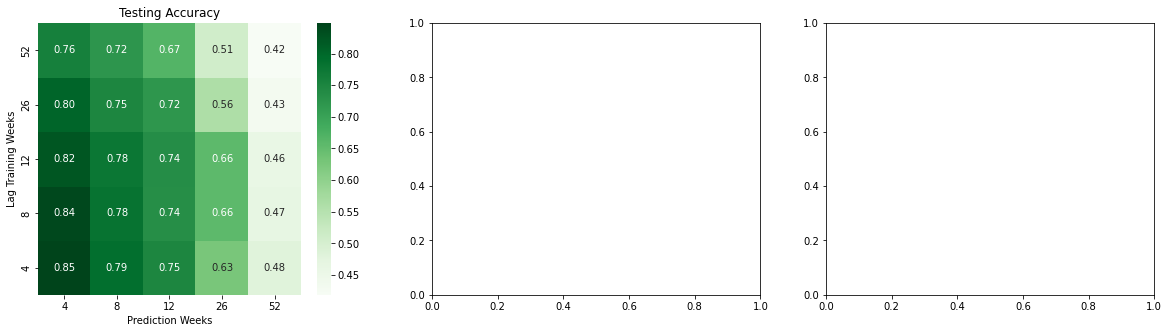

In [65]:
weeks = [4, 8, 12, 26, 52]
lags = [4, 8, 12, 26, 52]
results = [[d_score[(week, lag)] for lag in lags] for week in weeks]

fig, ax = plt.subplots(1,3, figsize = (20,5))

sb.heatmap(results, annot = True, cmap = 'Greens', fmt='.2f', ax = ax[0], xticklabels = weeks, yticklabels=lags)
ax[0].set_title('Testing Accuracy')
ax[0].set_xlabel('Prediction Weeks')
ax[0].set_ylabel('Lag Training Weeks')
ax[0].invert_yaxis()

# sb.heatmap(results[:,:,1], annot = True, cmap = 'Greens', fmt='.0f', ax = ax[1], xticklabels = weeks, yticklabels=lags)
# ax[1].set_title('Start Train: ' + start_train[1])
# ax[1].set_xlabel('Prediction Weeks')
# ax[1].set_ylabel('Lag Training Weeks')
# ax[1].invert_yaxis()

# sb.heatmap(results[:,:,2], annot = True, cmap = 'Greens', fmt='.0f', ax = ax[2], xticklabels = weeks, yticklabels=lags)
# ax[2].set_title('Start Train: ' + start_train[2])
# ax[2].set_xlabel('Prediction Weeks')
# ax[2].set_ylabel('Lag Training Weeks')
# ax[2].invert_yaxis()

plt.show()

#### Old EDA of a single county or group of counties

In [ ]:
# OLD EDA JUST FOR FUN

dates = pd.to_datetime(df_full[df_full['FIPS'] == FIPS[0]]['MapDate'])

fig,ax = plt.subplots(figsize=(10,10))

ln1 = ax.plot(dates, df_full[df_full['FIPS'] == FIPS[0]]['smap'], color = 'b', alpha = 0.5, label = 'SMAP')
ax.set_xlabel("measurement week")
ax.set_ylabel("smap")
ax.xaxis_date()

date_form = DateFormatter('%d-%m-%y')
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=30))

ax2=ax.twinx()
ln2 = ax2.plot(dates, df_full[df_full['FIPS'] == FIPS[0]]['roff'], color = 'r', alpha = 0.5, label = 'RunOff')
ln3 = ax2.plot(dates, df_full[df_full['FIPS'] == FIPS[0]]['evap'], color = 'g', alpha = 0.5, label = 'Evap')
ax2.set_ylabel("inches of roff or evap")

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)


fig.autofmt_xdate()

plt.show()

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.134
Model:                            OLS   Adj. R-squared (uncentered):              0.126
Method:                 Least Squares   F-statistic:                              17.98
Date:                Tue, 29 Mar 2022   Prob (F-statistic):                    7.09e-11
Time:                        14:18:37   Log-Likelihood:                         -2400.4
No. Observations:                 353   AIC:                                      4807.
Df Residuals:                     350   BIC:                                      4818.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

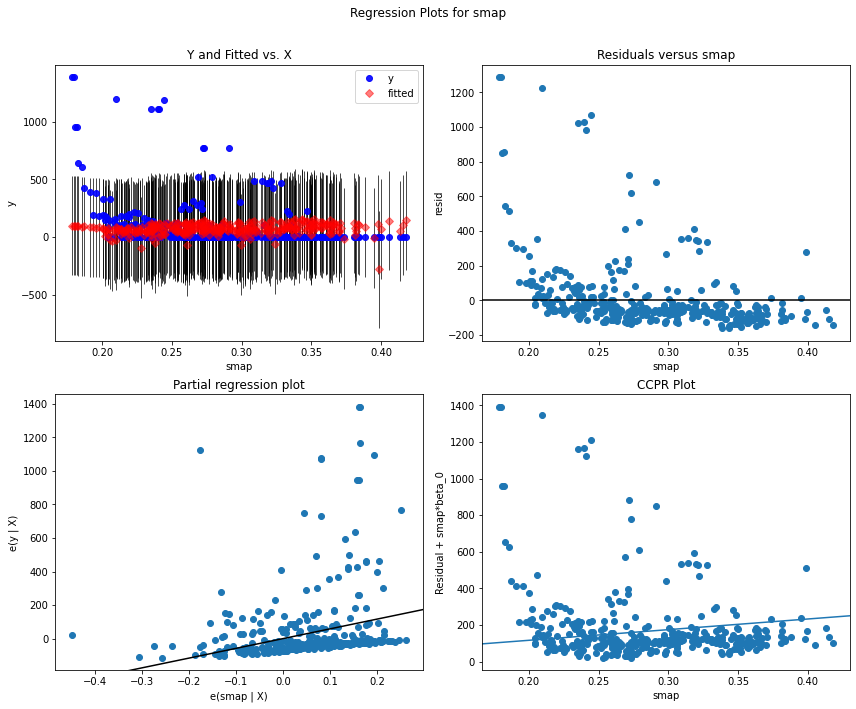

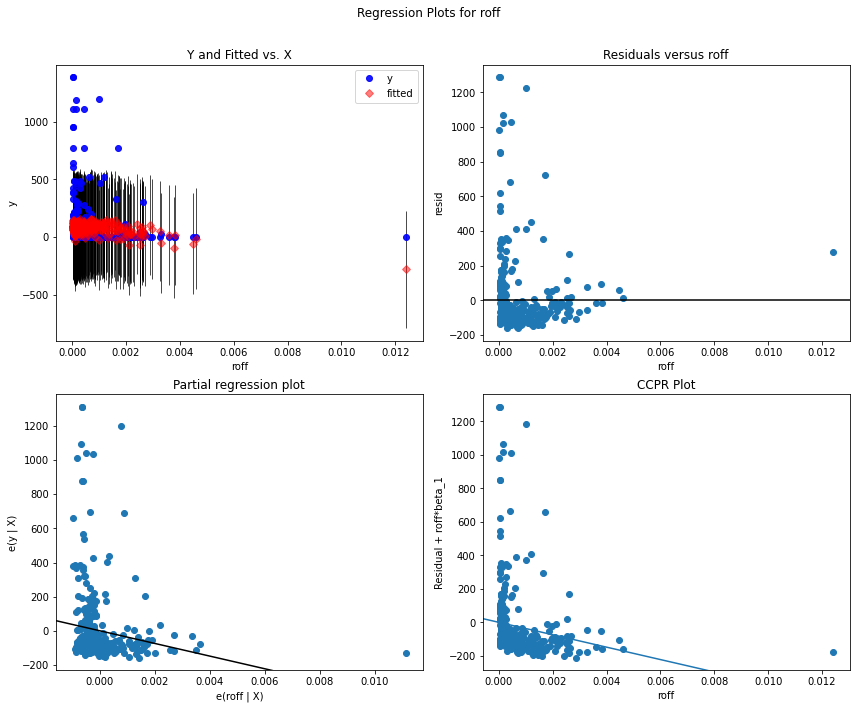

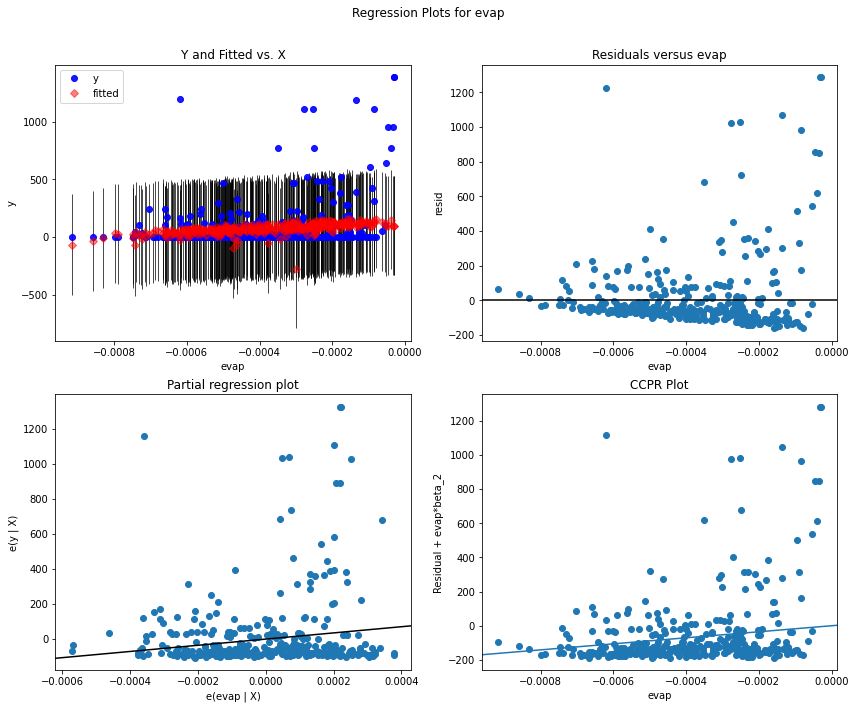

<Figure size 864x720 with 0 Axes>

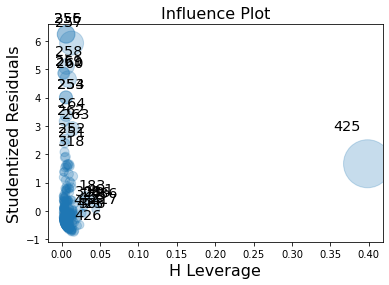

In [ ]:
#sample FIPS[0]

df_fips_0 = df_full[df_full['FIPS'] == FIPS[0]]
       
X_col = ['smap', 'roff', 'evap']
y_col = 'wsum'

X = df_fips_0[X_col]
y = np.array(df_fips_0[y_col]).reshape(-1,1)


lm = sm.OLS(y, X, missing = 'drop')
results = lm.fit()
print(results.summary())

fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 0, fig = fig)
plt.show()
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 1, fig = fig)
plt.show()
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 2, fig = fig)
plt.show()

fig = plt.figure(figsize=(12,10))
sm.graphics.influence_plot(results, fig = fig, plot_alpha=.25)
plt.show()





                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.173
Model:                            OLS   Adj. R-squared (uncentered):              0.166
Method:                 Least Squares   F-statistic:                              24.49
Date:                Tue, 29 Mar 2022   Prob (F-statistic):                    2.09e-14
Time:                        14:18:46   Log-Likelihood:                         -521.39
No. Observations:                 353   AIC:                                      1049.
Df Residuals:                     350   BIC:                                      1060.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

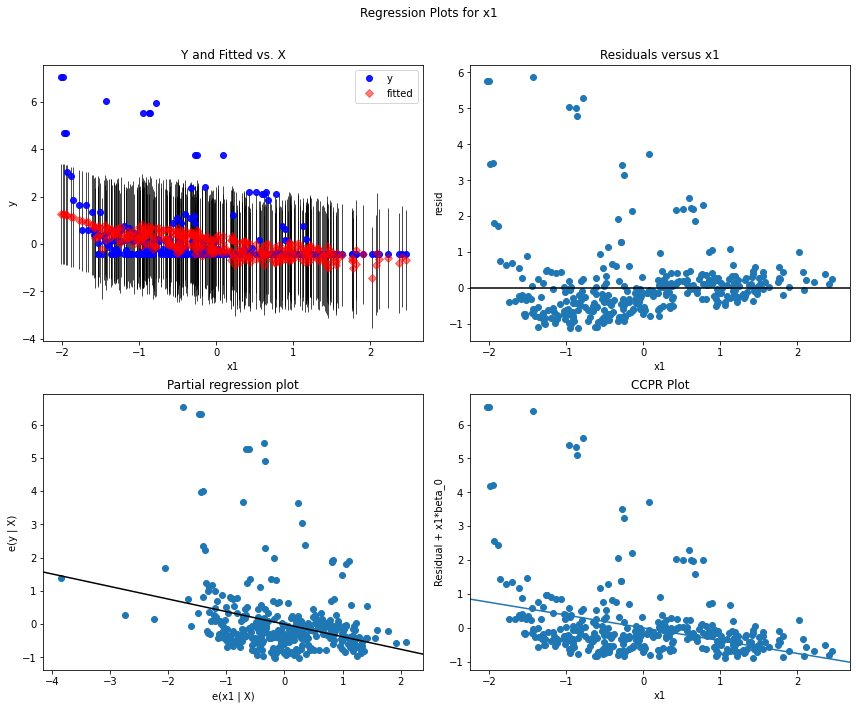

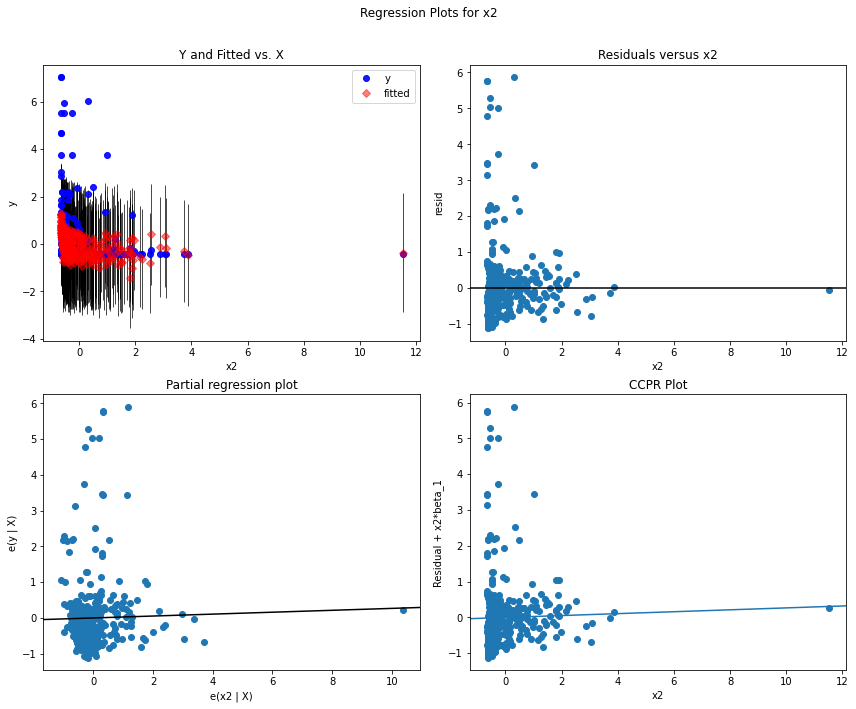

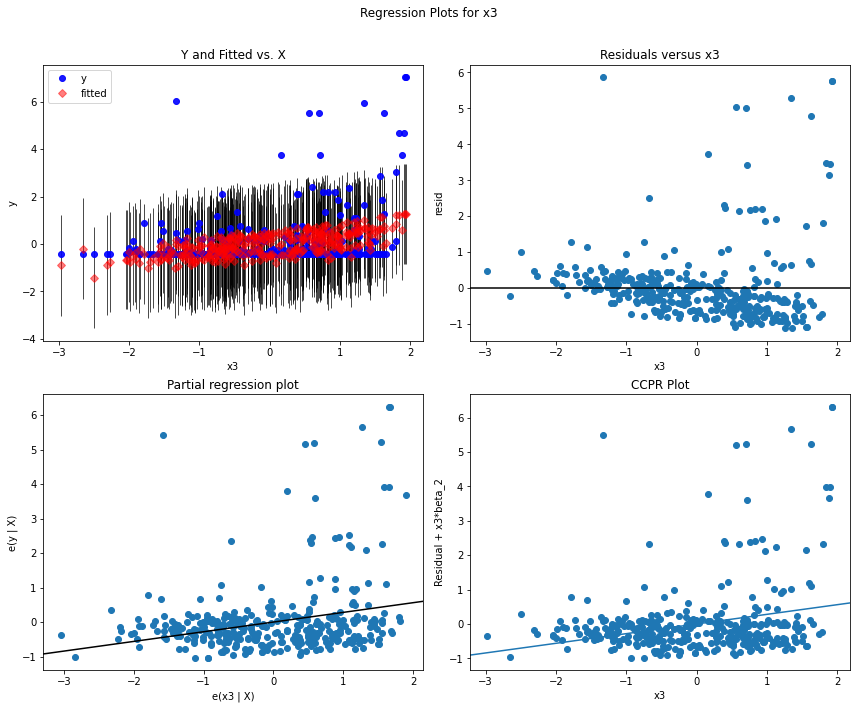

In [ ]:
#sample FIPS[0]

df_fips_0 = df_full[df_full['FIPS'] == FIPS[0]]
       
X_col = ['smap', 'roff', 'evap']
y_col = 'wsum'

X = df_fips_0[X_col]
y = np.array(df_fips_0[y_col]).reshape(-1,1)

scaler = StandardScaler()

X = scaler.fit_transform(X)

y = scaler.fit_transform(y)

lm = sm.OLS(y, X, missing = 'drop')
results = lm.fit()
print(results.summary())

fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 0, fig = fig)
plt.show()
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 1, fig = fig)
plt.show()
fig = plt.figure(figsize=(12,10))
sm.graphics.plot_regress_exog(results, 2, fig = fig)
plt.show()



<Figure size 864x720 with 0 Axes>

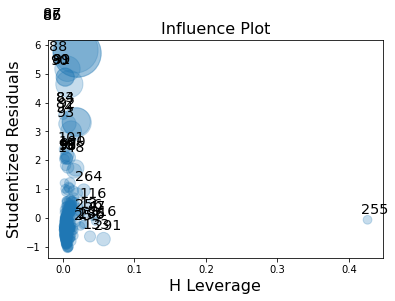

In [ ]:
# fig = plt.figure(figsize=(12,10))
# sm.graphics.plot_partregress_grid(results, fig = fig)
# plt.show()

fig = plt.figure(figsize=(12,10))
sm.graphics.influence_plot(results, fig = fig, plot_alpha=.25)
plt.show()
